In [270]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set display options to show all columns
pd.set_option('display.max_columns', None)

CWD = os.getcwd()
print(f'CWD: {CWD}')

CWD: /data_analysis/IT_support/src


In [271]:
ROOT = os.path.dirname(CWD)
PATH = os.path.join(ROOT, 'data', 'incident_event_log.csv')

df = pd.read_csv(PATH, low_memory=False, na_values='?')
df.sample(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
48734,INC0011099,Active,True,3,0,16,True,Caller 1250,Opened by 17,24/3/2016 13:41,Created by 10,24/3/2016 13:44,Updated by 307,26/4/2016 08:41,Phone,Location 143,Category 34,Subcategory 174,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 28,Resolver 78,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 30,15/8/2016 15:17,20/8/2016 16:00
51848,INC0011886,Active,True,5,0,7,True,Caller 1635,Opened by 402,28/3/2016 11:14,Created by 172,28/3/2016 11:21,Updated by 131,1/4/2016 17:46,Phone,Location 86,Category 37,Subcategory 123,Symptom 127,NaN,2 - Medium,2 - Medium,3 - Moderate,NaN,NaN,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 8,Resolved by 67,8/4/2016 15:32,13/4/2016 15:59
114529,INC0027794,Active,True,1,0,3,True,Caller 1110,Opened by 131,10/5/2016 09:37,NaN,NaN,Updated by 265,10/5/2016 11:57,Phone,Location 29,Category 53,Subcategory 80,Symptom 391,NaN,1 - High,1 - High,1 - Critical,Group 70,Resolver 73,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 15,13/5/2016 10:45,18/5/2016 11:07
28889,INC0006519,New,True,1,0,1,True,Caller 5546,Opened by 397,14/3/2016 10:02,Created by 171,14/3/2016 10:08,Updated by 44,14/3/2016 11:05,Phone,Location 161,Category 26,Subcategory 175,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,NaN,Resolver 24,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 9,Resolved by 22,16/3/2016 13:23,24/3/2016 19:00
27788,INC0006248,Closed,False,2,0,17,False,Caller 1089,Opened by 397,12/3/2016 00:43,Created by 171,12/3/2016 00:53,Updated by 908,12/4/2016 15:59,Phone,Location 204,Category 34,Subcategory 154,Symptom 102,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 25,Resolver 227,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 206,7/4/2016 15:28,12/4/2016 15:59


## Tickets

Tickets are logged everytime it is updated. This can be seen by showing all tickets with the same ticket `number`. Even for tickets that were reopened (`reopen_count` > 0), the `resolved_at` and `closed_at` columns only reflect the time & date of the last resolution and closing.

Based on `incident_response.txt` that details the description for each column, we split them to their appropriate data type. Most of them are categorical in nature. I separated those categories where *ranking* is of value into **ordinal columns**. For the remaining categorical columns, I split them into **boolean** (binary values) and **cardinal** (more than two values). One issue that I notice is that information is duplicated across incident states. By my understanding, some of these columns were only populated during a certain state, and should've been unknown at an earlier state. One example is `closed_code`, this information looks like it was only added at the last state and should be blank during earlier states. Since we don't have clear information as to when these columns' information were made known, we would exclude them in modelling.

In [272]:
cardinal_cols = ['number', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom',
                 'cmdb_ci', 'assignment_group', 'assigned_to', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by']
ordinal_cols = ['incident_state', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'impact', 'urgency', 'priority']

boolean_cols = ['active', 'made_sla', 'cmdb_ci', 'knowledge', 'u_priority_confirmation', 'notify']

dt_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']

len(cardinal_cols + ordinal_cols + boolean_cols + dt_cols)

37

In [273]:
cols = ['number', 'sys_mod_count', 'incident_state', 'caller_id', 'assignment_group',
        'opened_at', 'sys_updated_at', 'sys_created_at', 'closed_at', 'closed_code']
# cond = (df['number']=='INC0000065')
cond = (df['number']=='INC0000074')
# cond = (df['reassignment_count']>1)
df.loc[cond, cols]

,number,sys_mod_count,incident_state,caller_id,assignment_group,opened_at,sys_updated_at,sys_created_at,closed_at,closed_code
99,INC0000074,0,Active,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 08:23,NaN,16/4/2016 15:07,code 6
100,INC0000074,1,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 08:38,NaN,16/4/2016 15:07,code 6
101,INC0000074,2,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 14:16,NaN,16/4/2016 15:07,code 6
102,INC0000074,9,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,21/3/2016 11:07,NaN,16/4/2016 15:07,code 6
103,INC0000074,18,Resolved,Caller 527,Group 66,29/2/2016 08:23,11/4/2016 14:39,NaN,16/4/2016 15:07,code 6
104,INC0000074,19,Closed,Caller 527,Group 66,29/2/2016 08:23,16/4/2016 15:07,NaN,16/4/2016 15:07,code 6


Most of the *ordinal columns* are already numbers in string format. Three columns need a little bit of processing. One column `incident_state` is more difficult since we are not sure about the exact order of the states. There are some incidents that cycle between *Active* and  one of the *Awaiting ...* states. I think for now, since the *Awaiting ...* states are very few we can just cluster them into one and use this ordering: **New, Active, Awaiting, Resolved, Closed**.

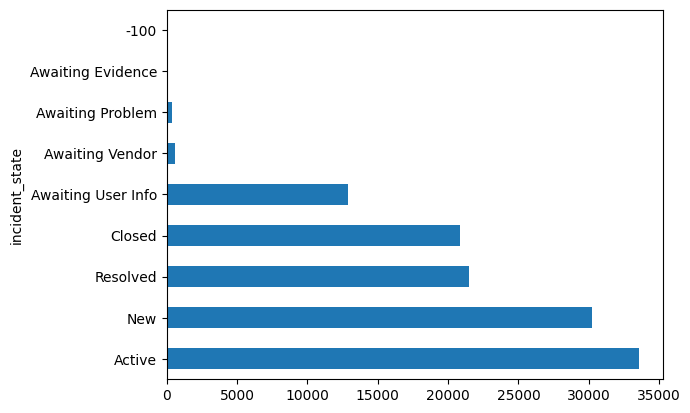

In [274]:
df['incident_state'].value_counts().plot(kind='barh');

The `sys_mod_count` tells us how many times a ticket is updated. It stands to reason that the max `sys_mod_count` for each `number` should be equal to the rows with that `number`. There are however multiple instances where this is not the case. It appears that there are missing rows for those incident tickets.

In [275]:
numbers = df.groupby('number')['number'].transform('count')
df.loc[df['sys_mod_count']>numbers, ['number', 'sys_mod_count']]

,number,sys_mod_count
84,INC0000070,9
102,INC0000074,9
103,INC0000074,18
104,INC0000074,19
135,INC0000084,14
...,...,...
119959,INC0029224,5
119986,INC0029229,16
119987,INC0029229,17
119993,INC0029231,8


### Changing of data types

In [276]:
for col in ['impact', 'urgency', 'priority']:
    df[col] = df[col].str.replace(r'\D', '', regex=True)

df.loc[df['incident_state'].str.contains('Awaiting'), 'incident_state'] = 'Awaiting'

for col in ordinal_cols:
    if col != 'incident_state':
        df[col] = df[col].astype(pd.CategoricalDtype(ordered=True))
    else:
        df[col] = df[col].astype(pd.CategoricalDtype(categories = ['New', 'Active', 'Awaiting', 'Resolved', 'Closed'], ordered=True))

df[ordinal_cols].sample(5)

,incident_state,reassignment_count,reopen_count,sys_mod_count,impact,urgency,priority
73809,Resolved,0,0,1,2,2,3
9221,New,0,0,0,2,2,3
67328,New,1,0,1,3,3,4
82435,Active,0,0,1,2,2,3
19942,Awaiting,5,0,10,2,2,3


In [277]:
for col in cardinal_cols:
    df[col] = df[col].astype(pd.CategoricalDtype(ordered=False))
for col in boolean_cols:
    df[col] = df[col].astype('bool')
for col in dt_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce').dt.floor('S')
df.dtypes

number                           category
incident_state                   category
active                               bool
reassignment_count               category
reopen_count                     category
sys_mod_count                    category
made_sla                             bool
caller_id                        category
opened_by                        category
opened_at                  datetime64[ns]
sys_created_by                   category
sys_created_at             datetime64[ns]
sys_updated_by                   category
sys_updated_at             datetime64[ns]
contact_type                     category
location                         category
category                         category
subcategory                      category
u_symptom                        category
cmdb_ci                            object
impact                           category
urgency                          category
priority                         category
assignment_group                 c

## Analysis

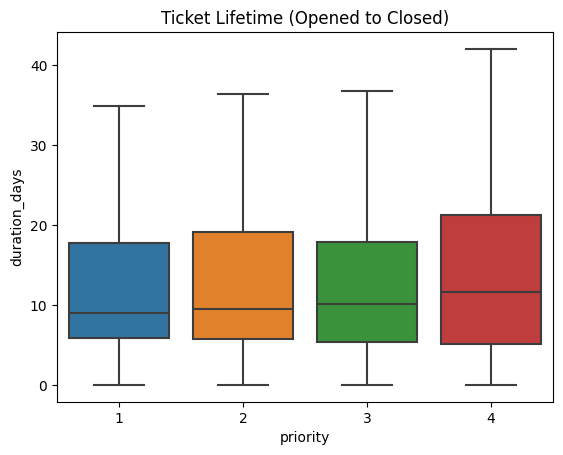

In [278]:
df['duration_days'] = df['closed_at']-df['opened_at']
df['duration_days'] = df['duration_days'].dt.days + df['duration_days'].dt.seconds / (24 * 60 * 60)
sns.boxplot(df, y='duration_days', x='priority', showfliers=False)
plt.title('Ticket Lifetime (Opened to Closed)')
plt.show()

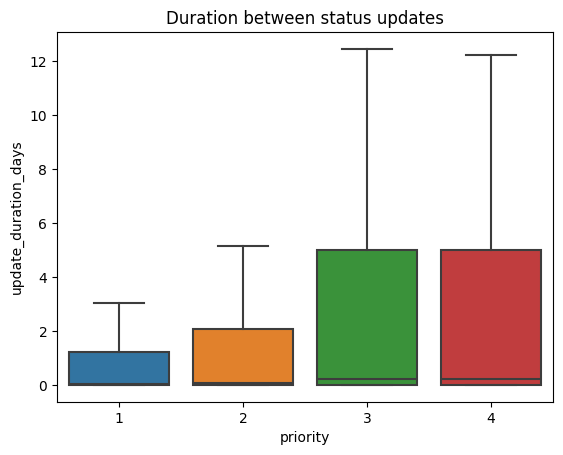

In [279]:
# Sort the DataFrame by 'number' and 'sys_updated_at'
df.sort_values(['number', 'sys_updated_at'], inplace=True)

# Calculate the time difference between updates for the same 'number'
df['update_duration_days'] = df.groupby('number')['sys_updated_at'].diff().dt.total_seconds() / (3600 * 24)
sns.boxplot(df, y='update_duration_days', x='priority', showfliers=False)
plt.title('Duration between status updates')
plt.show()

In [280]:
df['update_duration_days'].describe()

count    99229.000000
mean         2.864771
std          8.547687
min          0.000000
25%          0.004167
50%          0.204861
75%          5.004167
max        300.850694
Name: update_duration_days, dtype: float64

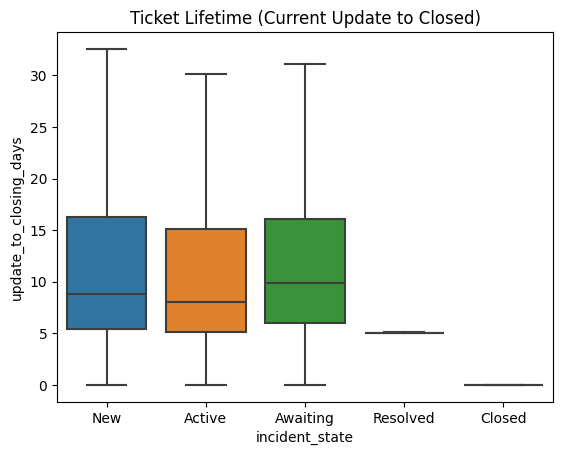

In [281]:
df['update_to_closing_days'] = df['closed_at']-df['sys_updated_at']
df['update_to_closing_days'] = df['update_to_closing_days'].dt.days + df['update_to_closing_days'].dt.seconds / (24 * 60 * 60)
sns.boxplot(df, y='update_to_closing_days', x='incident_state', showfliers=False)
plt.title('Ticket Lifetime (Current Update to Closed)')
plt.show()

### Missing values

In [282]:
df.loc[(df['sys_created_at'].isna()) & (df['incident_state']=='New'), 'priority'].value_counts()

priority
3    9132
2     316
1     263
4     192
Name: count, dtype: int64

In [283]:
df.loc[(df['sys_created_at'].isna()) & (df['incident_state']=='Closed'), 'sys_mod_count'].value_counts()

sys_mod_count
2     3264
1     1396
3     1228
4      601
5      405
      ... 
82       0
83       0
84       0
85       0
0        0
Name: count, Length: 115, dtype: int64

### Feature Engineering
We already did a bit of feature engineering in an earlier step when we computed the time between updates (`update_duration_days`) and the **target** (`update_to_closing_days`). The column `duration_days` cannot be used as feature because it leaks the closing information. Columns that give information regarding *resolution** or *closing* will also be removed. We will also be removing columns that we believe were only filled in as the ticket was being investigated but were broadcasted among all `incident_state`. We can *guess* that these items were filled in during the **Active** state, but there are tickets that have had multiple **Active** states so it is better to operate on minimal information. We also removed the `active` column since it only becomes **False** when the ticket is **Closed** except for one outlier (`Active==False & incident_state==Resolved`). The identifier `number` will only be dropped later as it will be used in train-test-split.

In [284]:
float_cols = ['update_duration_days', 'update_to_closing_days']
to_remove = ['duration_days', 'made_sla', 'knowledge', 'notify', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
             'assignment_group', 'assigned_to', 'category', 'subcategory', 'active']

all_cols = float_cols + ordinal_cols + cardinal_cols + boolean_cols + dt_cols
all_cols = [col for col in all_cols if col not in to_remove]

dt_cols = [col for col in dt_cols if col not in to_remove]

all_cols


['update_duration_days',
 'update_to_closing_days',
 'incident_state',
 'reassignment_count',
 'reopen_count',
 'sys_mod_count',
 'impact',
 'urgency',
 'priority',
 'number',
 'caller_id',
 'opened_by',
 'sys_created_by',
 'sys_updated_by',
 'contact_type',
 'location',
 'u_symptom',
 'cmdb_ci',
 'cmdb_ci',
 'u_priority_confirmation',
 'opened_at',
 'sys_created_at',
 'sys_updated_at']

We split the *Date time columns* into its components so the algorithms can handle them.

In [285]:
df = df[all_cols].copy()
for col in dt_cols:
    for component in ['year', 'month', 'day', 'hour', 'minute', 'second']:
        new_col_name = f'{col}_{component}'  # Create a dynamic column name
        df[new_col_name] = df[col].dt.__getattribute__(component).astype(float)
df.drop(columns=dt_cols, inplace=True)
df.sample()

,update_duration_days,update_to_closing_days,incident_state,reassignment_count,reopen_count,sys_mod_count,impact,urgency,priority,number,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,u_symptom,cmdb_ci,cmdb_ci,u_priority_confirmation,opened_at_year,opened_at_month,opened_at_day,opened_at_hour,opened_at_minute,opened_at_second,sys_created_at_year,sys_created_at_month,sys_created_at_day,sys_created_at_hour,sys_created_at_minute,sys_created_at_second,sys_updated_at_year,sys_updated_at_month,sys_updated_at_day,sys_updated_at_hour,sys_updated_at_minute,sys_updated_at_second
103082,0.801389,6.097222,New,0,0,2,2,2,3,INC0024975,Caller 187,Opened by 24,Created by 13,Updated by 859,Phone,Location 93,NaN,NaN,NaN,False,2016.0,5.0,2.0,14.0,30.0,0.0,2016.0,5.0,2.0,14.0,32.0,0.0,2016.0,5.0,3.0,9.0,47.0,0.0
